In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(
    'ignore', 'invalid value encountered in double_scalars')


# Discussion 1: Determine the best period (time) for model training.

In [2]:
# Set different start dates
start_dates = ['2012-03-01', '2013-03-01', '2014-03-01',
               '2015-03-01', '2016-03-01', '2017-03-01',
               '2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01']

# Set end date for historical price data
end_date = '2023-03-01'

# Set empty lists to store evaluation metrics
r2_svr_train_list = []
r2_svr_test_list = []
mse_svr_train_list = []
mse_svr_test_list = []
mae_svr_train_list = []
mae_svr_test_list = []

r2_rfr_train_list = []
r2_rfr_test_list = []
mse_rfr_train_list = []
mse_rfr_test_list = []
mae_rfr_train_list = []
mae_rfr_test_list = []

for i, start_date in enumerate(start_dates):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame for each start date
    df = yf.download("GOOGL", start=start_date,
                     end=end_date, progress=False)

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-20)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=30, shuffle=False)

    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    # Fit the SVR model with a constant term
    X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
    X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

    svr_model.fit(X_train_with_const, y_train)

    # # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train_with_const)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test_with_const)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)
    
    r2_svr_train_list.append(r2_svr_train)
    mse_svr_train_list.append(mse_svr_train)
    mae_svr_train_list.append(mae_svr_train)

    r2_svr_test_list.append(r2_svr_test)
    mse_svr_test_list.append(mse_svr_test)
    mae_svr_test_list.append(mae_svr_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)
    
    r2_rfr_train_list.append(r2_rfr_train)
    mse_rfr_train_list.append(mse_rfr_train)
    mae_rfr_train_list.append(mae_rfr_train)
    r2_rfr_test_list.append(r2_rfr_test)
    mse_rfr_test_list.append(mse_rfr_test)
    mae_rfr_test_list.append(mae_rfr_test)

svr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    svr_row = [year, r2_svr_train_list[i], r2_svr_test_list[i], mse_svr_train_list[i],
            mse_svr_test_list[i], mae_svr_train_list[i], mae_svr_test_list[i]]
    svr_table.append(svr_row)

print("SVR Model")
print(tabulate(svr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

rfr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    rfr_row = [year, r2_rfr_train_list[i], r2_rfr_test_list[i], mse_rfr_train_list[i],
            mse_rfr_test_list[i], mae_rfr_train_list[i], mae_rfr_test_list[i]]
    rfr_table.append(rfr_row)

print("RFR Model")
print(tabulate(rfr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


SVR Model
╒════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│   Year │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│   2012 │     0.969767 │   0.761148  │       9.90512 │      83.0717 │       2.03609 │      7.16402 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2013 │     0.962839 │   0.715119  │      12.4726  │      92.4739 │       2.2817  │      7.45486 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2014 │     0.962511 │   0.696998  │      14.7293  │     104.405  │       2.53621 │      7.87126 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2015 │     0.965628 │   0.692666  │      16.6443  │     118.246  │  

Ans: SVR model is good with data starting from 2012, while RFR model is good with data starting from 2015. Overall, I will continue with Year 2015, since both model can perform prediction.

# Discussion 2: Determine how well can SVR & RFR model predict future stock price.

In [3]:
def evaluate_train_test(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    result_table = []

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table.append(svr_result)
    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [4]:
def evaluate_train_test_svr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    result_table = []

    result_table.append(svr_result)
    
    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [5]:
def evaluate_train_test_rfr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table = []

    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


## Base Model

In [6]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [7]:
evaluate_train_test(X_train, X_test)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692667 │      16.6443  │      118.246 │      2.75005  │      8.61792 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995668 │    0.701868 │       2.09756 │      114.706 │      0.979002 │      9.13135 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.582544 │       11.9469  │        2.71221 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.803673 │        5.61852 │        1.89272 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


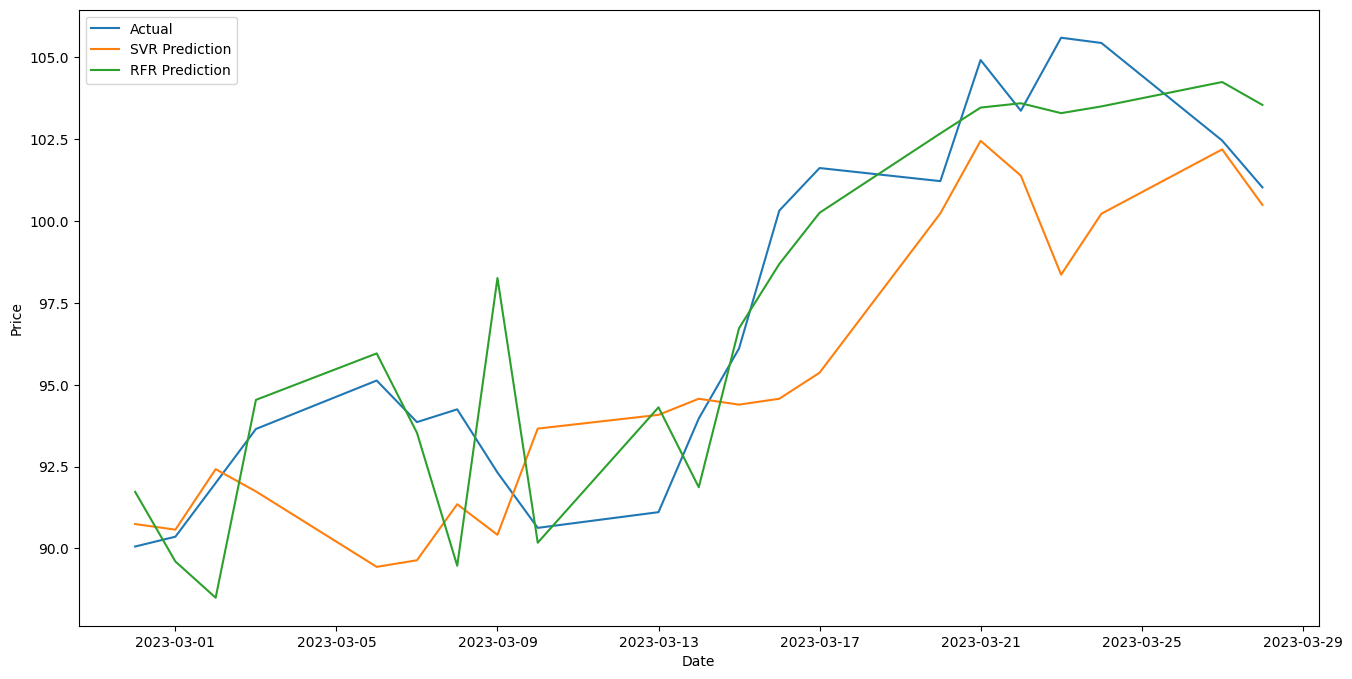

In [8]:
# Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add constant

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692666 │      16.6443  │      118.246 │      2.75005  │      8.61794 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995687 │    0.704123 │       2.08841 │      113.838 │      0.976529 │      9.07457 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.582548 │       11.9467  │        2.7122  │
├─────────┼───────────────┼────

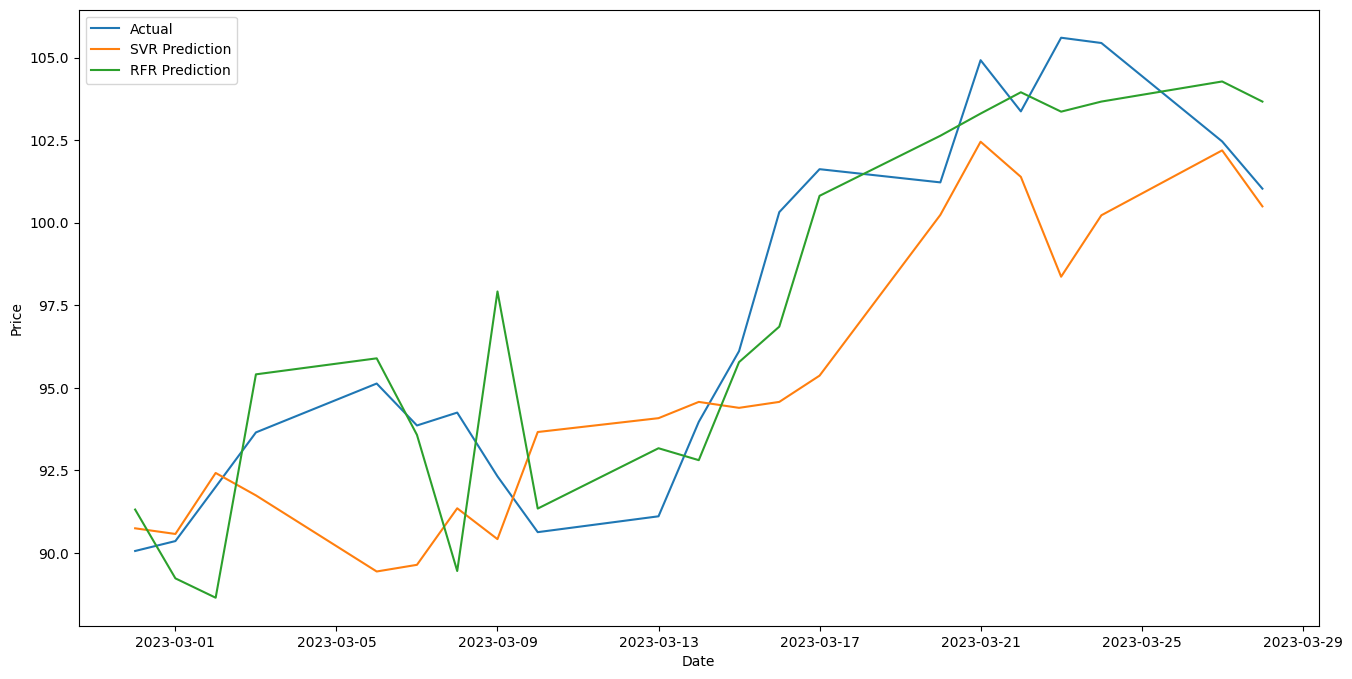

In [9]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_with_const, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_with_const, y_train)

evaluate_train_test(X_train_with_const, X_test_with_const)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_with_const)
y_rfr_pred = rfr_model.predict(X_pred_with_const)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add Feature Selection using correlation coefficient


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │       16.6461 │      118.915 │       2.75058 │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995461 │    0.710839 │        2.1982 │      111.254 │       1.00189 │      8.95766 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.58726  │       11.8119  │        2.69202 │
├─────────┼───────────────┼────

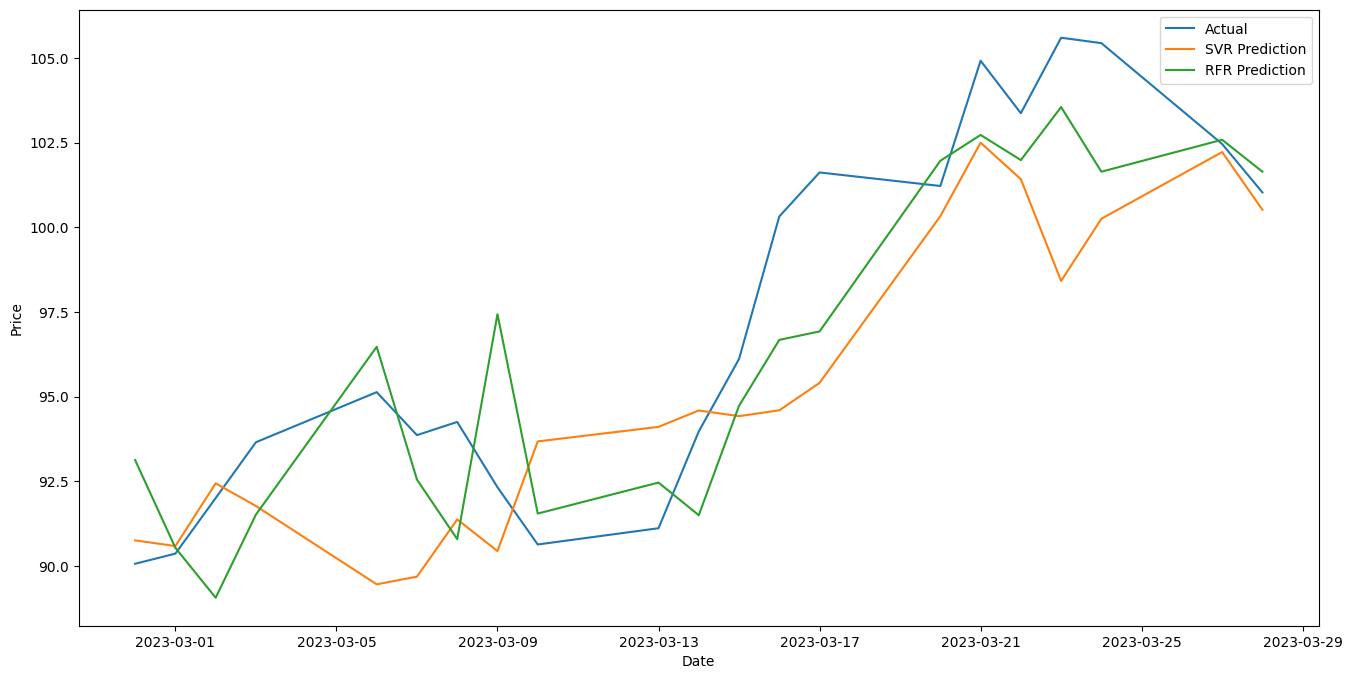

In [10]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_with_const, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_with_const, y_train)


evaluate_train_test(X_train_with_const, X_test_with_const)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_with_const)
y_rfr_pred = rfr_model.predict(X_pred_with_const)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


It makes RFR model slightly bad, but the SVR is slightly better. 

## Add PCA

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │      16.6461  │      118.915 │      2.75058  │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995527 │    0.687282 │       2.16603 │      120.318 │      0.992996 │      9.29562 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.587258 │        11.8119 │        2.69203 │
├─────────┼───────────────┼────

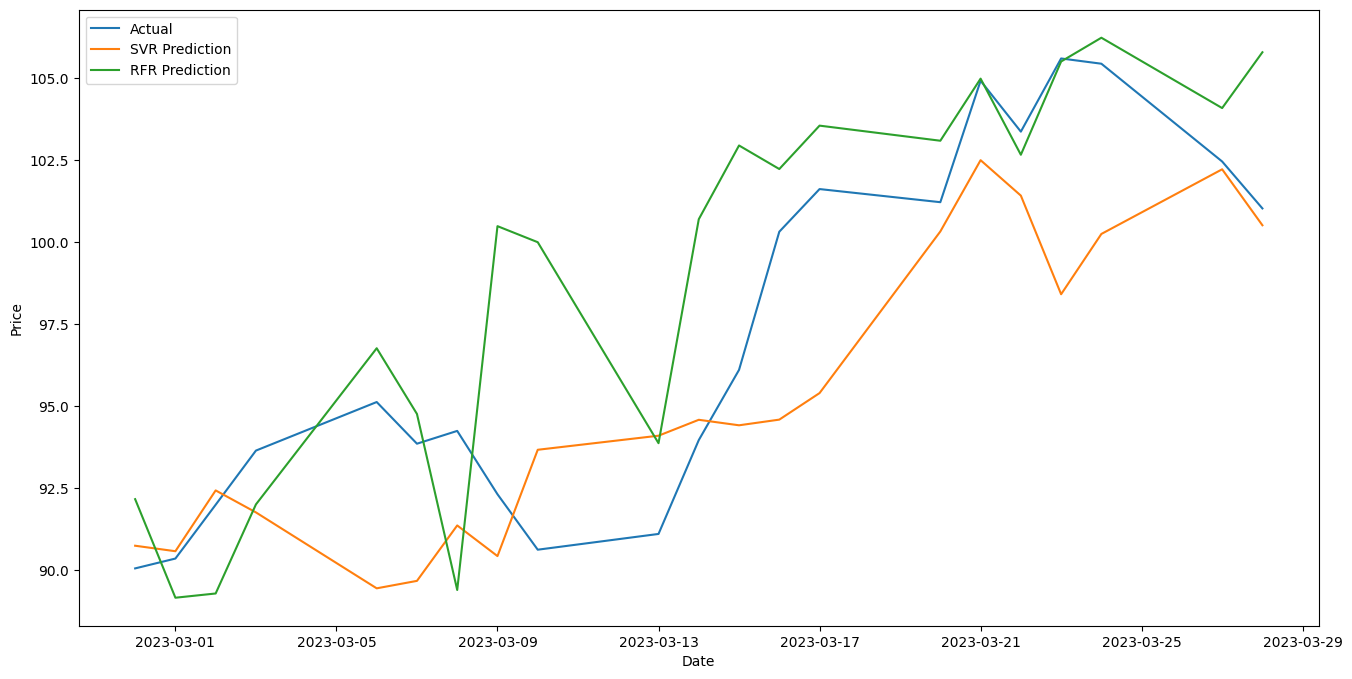

In [11]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Initialize the PCA model:
pca_model = PCA(n_components=6)

# Fit the PCA model to the training data:
pca_model.fit(X_train_with_const)
X_train_pca = pca_model.transform(X_train_with_const)
X_test_pca = pca_model.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_pca, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_pca, y_train)

evaluate_train_test(X_train_pca, X_test_pca)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_pca = pca_model.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_pca)
y_rfr_pred = rfr_model.predict(X_pred_pca)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


After using PCA, it makes RFR model become worse. For SVR, the model has become slightly bad compare with previous. 

## Add PolynomialFeatures

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.96585  │    0.690284 │      16.5369  │      119.163 │       2.7439  │      8.68446 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995335 │    0.720833 │       2.25906 │      107.409 │       1.00417 │      8.80416 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.623343 │       10.7793  │        2.58461 │
├─────────┼───────────────┼────

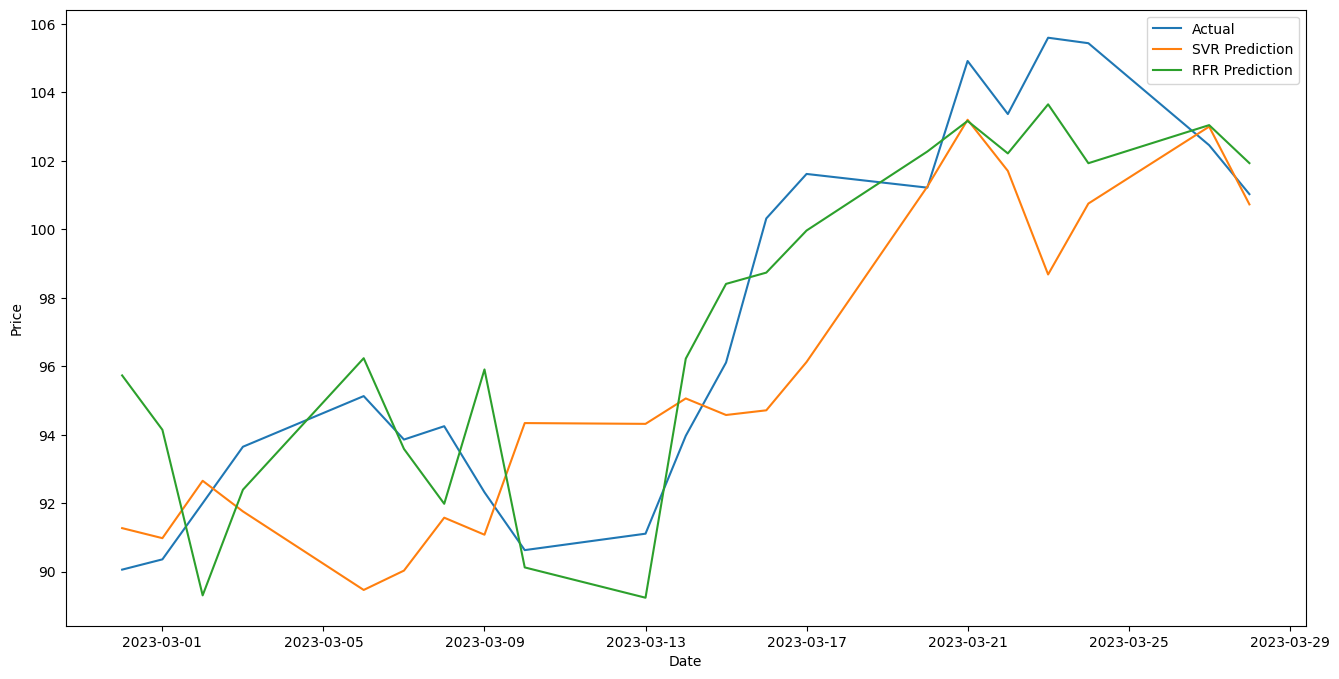

In [12]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

RFR models has been doing well right now. However, SVR still need to perform extra techinque.

## Add Features by using Technical Indicators 

SVR only. since RFR do very well aldy.

In [13]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=10)
svr_model.fit(X_train_poly, y_train)

evaluate_train_test_svr(X_train_poly, X_test_poly)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.966386 │    0.668753 │       16.6882 │      128.219 │       2.77082 │      9.07292 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.657479 │        9.80233 │        2.58351 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.80572  │        5.55994 │        1.98601 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


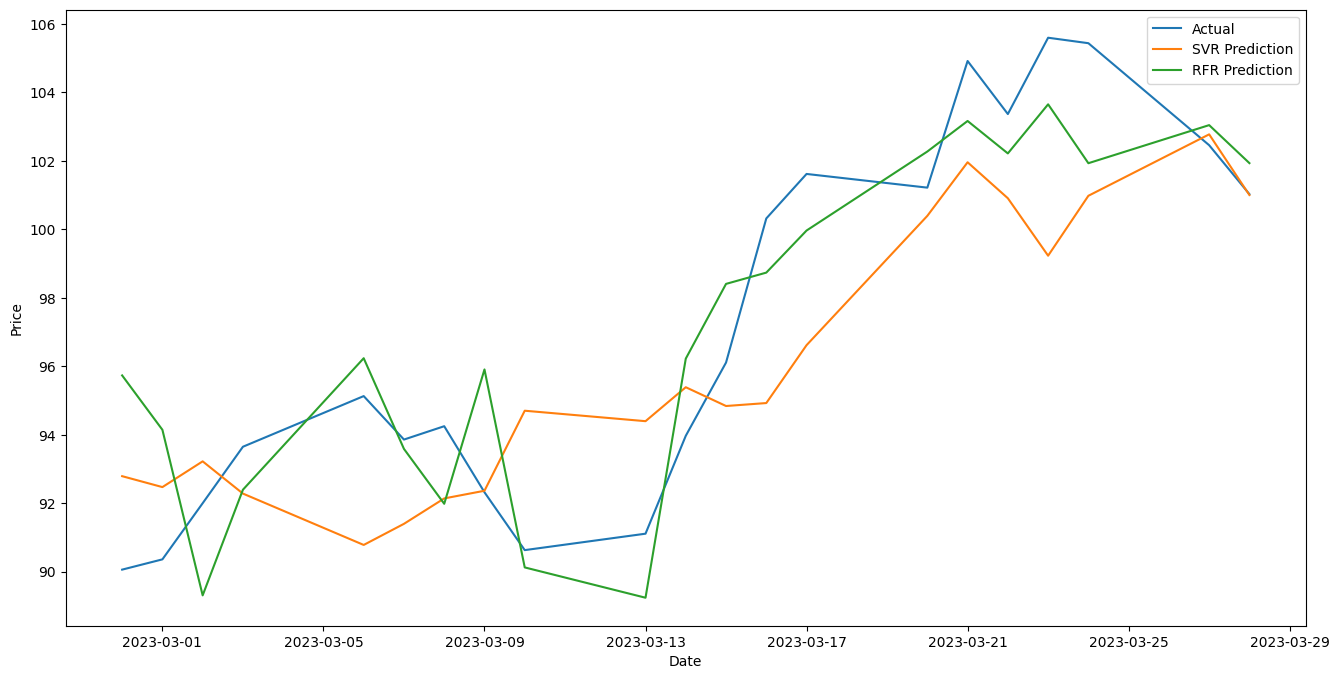

In [14]:
# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Apply GridSearchCV

RFR Model

In [18]:
result_table = []

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_poly, y_train)

# Get the best model
rfr_model = grid_search_rfr.best_estimator_

# Calculate evaluation metrics for RFR model
y_rfr_pred_train = rfr_model.predict(X_train_poly)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

y_rfr_pred_test = rfr_model.predict(X_test_poly)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]
result_table.append(rfr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_rfr_pred = rfr_model.predict(X_pred_poly)

SVR model

In [19]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10, 100],
    'gamma': ['auto', 'scale'],
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_poly, y_train)

# Get the best model
svr_model = grid_search_svr.best_estimator_

# Calculate evaluation metrics for SVR model
y_svr_pred_train = svr_model.predict(X_train_poly)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

y_svr_pred_test = svr_model.predict(X_test_poly)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

result_table.append(svr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

Evaluate SVR & RFR Performance Based on Actual Data

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.690733 │        8.85066 │        2.47256 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.867065 │        3.80436 │        1.77027 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


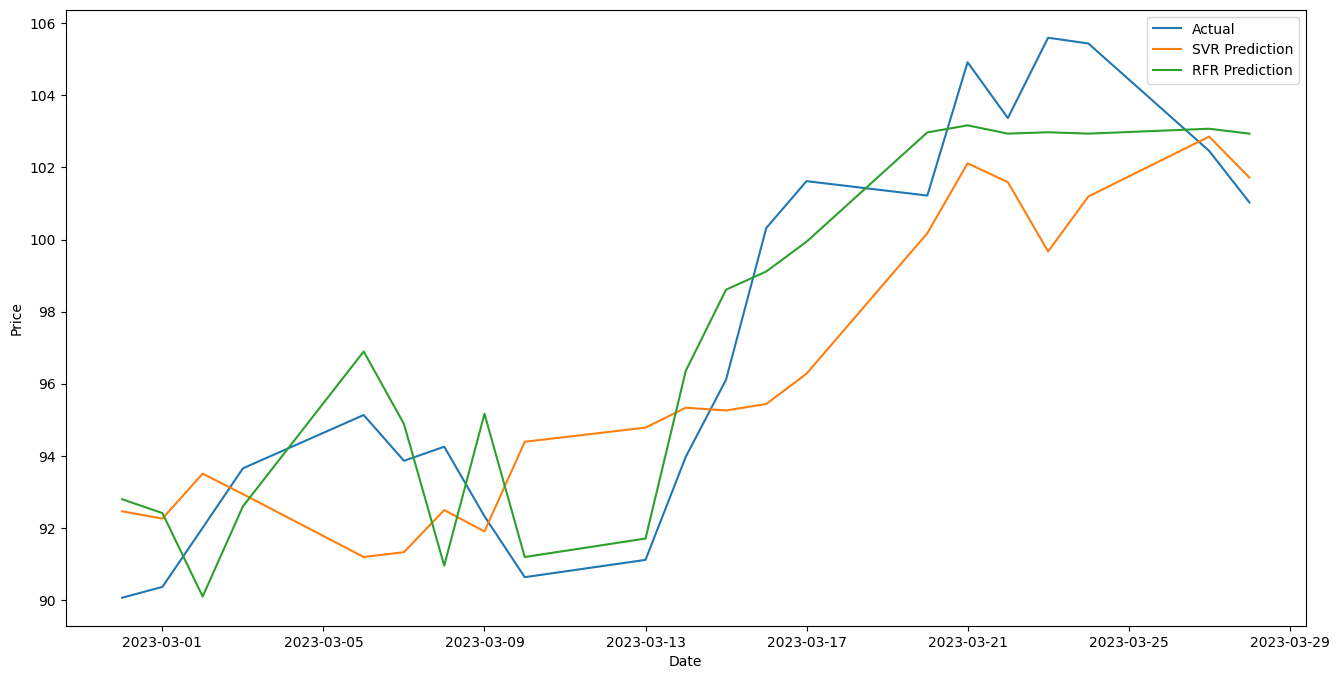

In [20]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Ensemble Model (RFR + SVR)

In [21]:
from sklearn.ensemble import VotingRegressor

# Use VotingRegressor to combine RFR and SVR models
ensemble_model = VotingRegressor(estimators=[('rfr', rfr_model), ('svr', svr_model)])
ensemble_model.fit(X_train_poly, y_train)

y_ensemble_pred_train = ensemble_model.predict(X_train_poly)
r2_ensemble_train = r2_score(y_train, y_ensemble_pred_train)
mse_ensemble_train = mean_squared_error(y_train, y_ensemble_pred_train)
mae_ensemble_train = mean_absolute_error(y_train, y_ensemble_pred_train)

y_ensemble_pred_test = ensemble_model.predict(X_test_poly)
r2_ensemble_test = r2_score(y_test, y_ensemble_pred_test)
mse_ensemble_test = mean_squared_error(y_test, y_ensemble_pred_test)
mae_ensemble_test = mean_absolute_error(y_test, y_ensemble_pred_test)

ensemble_result = ["Ensemble", r2_ensemble_train, r2_ensemble_test, mse_ensemble_train,
            mse_ensemble_test, mae_ensemble_train, mae_ensemble_test]

result_table.append(ensemble_result)

y_ensemble_pred = ensemble_model.predict(X_pred_poly)

In [22]:
# Calculate evaluation metrics for train & test set from each model
print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                    "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

╒══════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model    │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞══════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ RFR      │     0.986292 │    0.694346 │       6.63793 │     117.6    │       1.74061 │      9.32565 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ SVR      │     0.966169 │    0.691356 │      16.7959  │     119.47   │       2.7963  │      8.68534 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ Ensemble │     0.980943 │    0.7444   │       9.46094 │      98.9379 │       2.06023 │      7.88693 │
╘══════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒══════════╤═══════════════╤════════════════╤════════════════╕
│ Model    │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞══════════╪═══════════════╪════════════════╪════════════════╡
│ SVR      │      0.690733 │        8.85066 │        2.47256 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ RFR      │      0.867065 │        3.80436 │        1.77027 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ Ensemble │      0.820412 │        5.1395  │        1.82508 │
╘══════════╧═══════════════╧════════════════╧════════════════╛


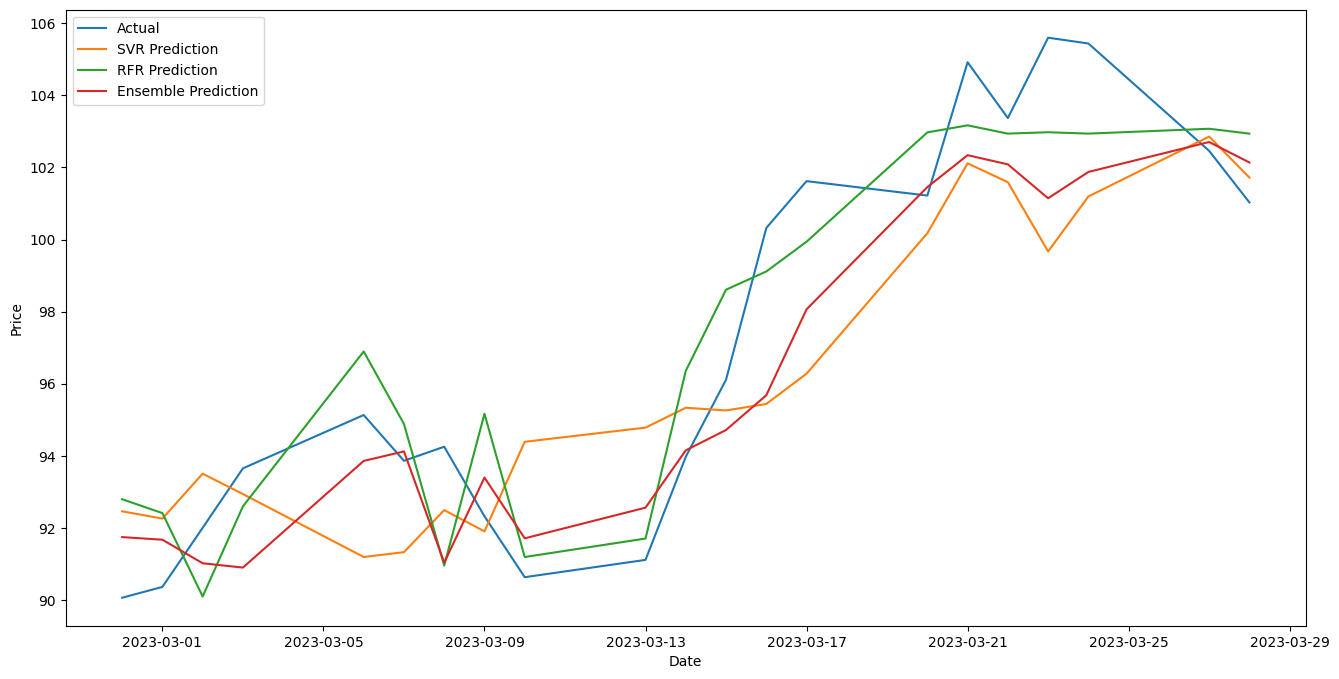

In [23]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred,
                        'Ensemble Predcition': y_ensemble_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for ensemble model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Calculate evaluation metrics for RFR model
r2_ensemble_actual = r2_score(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mse_ensemble_actual = mean_squared_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mae_ensemble_actual = mean_absolute_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual],
         ["Ensemble", r2_ensemble_actual, mse_ensemble_actual, mae_ensemble_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.plot(df_combined.index,
         df_combined['Ensemble Predcition'], label='Ensemble Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import lime.lime_tabular
import numpy as np

# assuming 'ensemble_model' is your trained regression ensemble model
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_poly, 
                                                   mode='regression',
                                                   feature_names=feature_names, 
                                                   class_names=None, 
                                                   discretize_continuous=False)

def predict_proba(X):
    preds = ensemble_model.predict(X)
    return np.column_stack((preds,))

# explain a single instance using the LIME explainer
exp = explainer.explain_instance(X_test_poly[0], predict_proba, num_features=len(feature_names))

In [71]:
X

,Open,High,Low,Close,Adj Close,SMA_10,EMA_10
Date,,,,,,,
2015-04-17,26.865499,26.990000,26.450001,26.636999,26.636999,27.19965,27.196931
2015-04-20,26.687500,27.290001,26.667500,27.226500,27.226500,27.20255,27.202307
2015-04-21,27.315500,27.388500,27.110500,27.146000,27.146000,27.19285,27.192069
2015-04-22,27.153000,27.549999,27.066000,27.459000,27.459000,27.19455,27.240602
2015-04-23,27.520500,28.058500,27.504000,27.872999,27.872999,27.24175,27.355584
...,...,...,...,...,...,...,...
2023-01-24,98.099998,99.610001,97.199997,97.699997,97.699997,93.41600,94.239734
2023-01-25,95.570000,96.160004,93.760002,95.220001,95.220001,94.09600,94.417965
2023-01-26,96.500000,97.570000,95.379997,97.519997,97.519997,94.69600,94.981970
